# Import Libraries and set paths for directories

In [10]:
#Importing libraries, setting global variables and setting directories

import tensorflow as tf
import random
from pathlib import Path
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, ZeroPadding2D, Convolution2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras import optimizers, applications
import numpy as np
import pandas as pd
import cv2
import os
from os import path
import shutil
import zipfile
import unittest
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
import matplotlib 
import itertools

rootdirectory = "data/"
modalweights = rootdirectory + 'weights.hdf5'
resnetw = rootdirectory + 'Resnet.hdf5'
VGGweights = rootdirectory + 'VGGweights.hdf5'
train_labels = pd.read_csv(rootdirectory + 'train_labels.csv')

tf.random.set_seed(2)

#declare original size of image 
originalsize = 96
#size after cropping
cropS = 75 
#set rotation value
randrot = 3 
#centre crop shift in x and y axis
randshift = 2 
#change brightness
randbrightness = 6
#change contrast value
randcontrast = 6
#rotate 90 degrees if value is 1
rand90turn = 1
#rotation value
RANDOM_ROTATION = 3

# Read in CSV file


The CSV files provided show the correct label for each image this must be read and converted into a dataframe in order for it to be used in the Image data generator. A function is implemented to convert the tif files to the dataframe.

In [2]:
train_dir = "data/train1/happy"
x_col="label"
y_col="id"

def append_ext(fn):
    return fn+".tif"

traindf=pd.read_csv("data/train_labels.csv", dtype=str)
traindf["id"]=traindf["id"].apply(append_ext)

testdf=pd.read_csv("data/sample_submission.csv", dtype=str)
testdf["id"]=testdf["id"].apply(append_ext)

shorttestdf=pd.read_csv("data/shortdata.csv", dtype=str)
shorttestdf["id"]=testdf["id"].apply(append_ext)

actual = pd.read_csv("data/sample_submission.csv", dtype=str)
shorttestdf["id"]=testdf["id"].apply(append_ext)

# print("File exists:"+str(path.exists(train_dir+ '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')))

# ImageDataGenerators to pre-process and feed the data to the neural network in real time

In [5]:
datagen=ImageDataGenerator(rescale=1.0/255.0,
brightness_range=[0.5, 1.0],
horizontal_flip=True,
vertical_flip=True,
zoom_range=0.6)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
dataframe=traindf[:-1],
directory="data/train1/",
x_col="id",
y_col="label",
batch_size=128,
seed=42,
shuffle=True,
class_mode="binary",
classes=["0", "1"],
rotation_range=48,
target_size=(75,75))

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf[:-1],
directory="data/test/",
x_col="id",
batch_size=128,
seed=42,
shuffle=False,
class_mode=None,
#classes=["0", "1"],
target_size=(75,75))


valid_generator=test_datagen.flow_from_dataframe(
dataframe=traindf[:-1],
directory="data/validation/",
x_col="id",
y_col="label",
#subset="training",
batch_size=128,
seed=42,
shuffle=False,
class_mode="binary",
classes=["0", "1"],
target_size=(75,75))

C:\FYPsetup\envs\testsetup\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:270: UserWarning: Found 44005 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


Found 176019 validated image filenames belonging to 2 classes.
Found 57457 validated image filenames.
Found 44005 validated image filenames belonging to 2 classes.


C:\FYPsetup\envs\testsetup\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:270: UserWarning: Found 176019 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [6]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(valid_generator.batch_size)

STEP_SIZE_TEST=344
# STEP_SIZE_TEST_RN = 344
#print(train_generator.n)

1375
343
128


# Unit tests to ensure variables are set correctly to ensure entire dataset is covered

In [ ]:
class TestDemo(unittest.TestCase):
     def test(self):                             
        result = STEP_SIZE_TEST
        expectedResult = 2000
        self.assertGreaterEqual(result, expectedResult)

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

In [ ]:
class TestDemo(unittest.TestCase):
     def test(self):                             
        result =train_generator.n//train_generator.batch_size
        expectedResult = 1375
        self.assertGreaterEqual(result, expectedResult)

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

test for validation generator

In [ ]:
class TestDemo(unittest.TestCase):
     def test(self):                             
        result =valid_generator.n//valid_generator.batch_size
        expectedResult = 343
        self.assertGreaterEqual(result, expectedResult)

In [ ]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

# Function for Confusion Matrix

In [7]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
cm_plot_labels = ['0','1']

## 3x3 Model

In [144]:
#building a CNN

model = Sequential()
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu', input_shape = (60, 60, 3)))
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizers.RMSprop(lr=0.0001, decay=1e-6),loss='binary_crossentropy',metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_394 (Conv2D)          (None, 60, 60, 32)        896       
_________________________________________________________________
conv2d_395 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
conv2d_396 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
dropout_27 (Dropout)         (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_397 (Conv2D)          (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_398 (Conv2D)          (None, 20, 20, 64)      

Train 3x3 model

In [146]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3)
checkpoint = ModelCheckpoint(filepath = rootdirectory + "weights.hdf5", verbose=1, save_best_only=True)

history3 = model.fit(train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN,
      validation_data=valid_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks = [early_stopping, checkpoint],
      epochs=10)

history3.history.keys()

Epoch 1/10
687/687 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7532
Epoch 00001: val_loss improved from inf to 0.48294, saving model to data\weights.hdf5
687/687 [==============================] - 2989s 4s/step - loss: 0.5134 - accuracy: 0.7532 - val_loss: 0.4829 - val_accuracy: 0.7770
Epoch 2/10
687/687 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.7878
Epoch 00002: val_loss did not improve from 0.48294
687/687 [==============================] - 2959s 4s/step - loss: 0.4574 - accuracy: 0.7878 - val_loss: 0.4891 - val_accuracy: 0.7677
Epoch 3/10
687/687 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.7994
Epoch 00003: val_loss improved from 0.48294 to 0.47299, saving model to data\weights.hdf5
687/687 [==============================] - 2942s 4s/step - loss: 0.4375 - accuracy: 0.7994 - val_loss: 0.4730 - val_accuracy: 0.7760
Epoch 4/10
687/687 [==============================] - ETA: 0s - loss: 0.4199 - accurac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

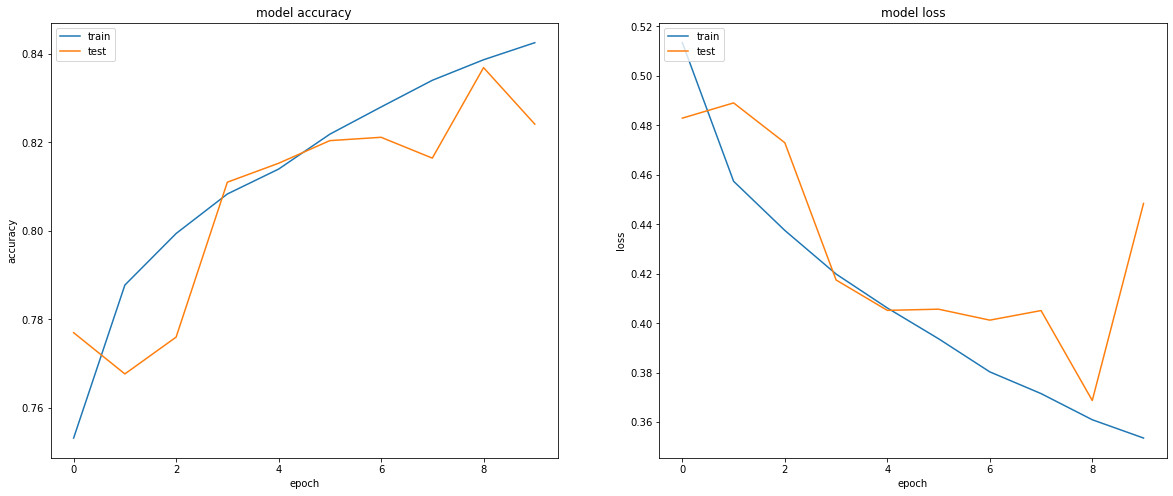

In [147]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#summarize history for loss
plt.subplot(1,2,2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Try the model on unseen data and extract evaluation metrics from the test

In [160]:
#print(STEP_SIZE_TEST)
test_generator.reset()
model.load_weights(modalweights)

y_pred_keras= model.predict(valid_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1).ravel()

print("validation accuracy = " + str(y_pred_keras[1]))


344/344 [==============================] - 274s 798ms/step
validation accuracy = 0.7818216


Confusion matrix, without normalization
[[20693  5528]
 [ 6167 11617]]


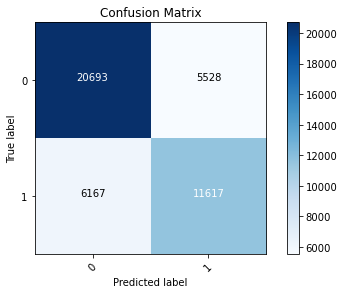

In [149]:
cm = confusion_matrix(y_true=valid_generator.classes, y_pred=probabilities>0.5)

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

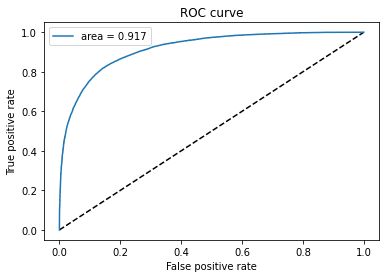

In [161]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Test the model on Test data

In [152]:
model.load_weights(modalweights)

testing = model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1).ravel()

print("Test accuracy = " + str(testing[1]))

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000025DBDA99280>
Traceback (most recent call last):
  File "C:\FYPsetup\envs\testsetup\lib\weakref.py", line 346, in remove
    self = selfref()
KeyboardInterrupt: 


344/344 [==============================] - 504s 1s/step
Test accuracy = 0.32599473


## VGG16

In [14]:
#call in VGG model
base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(75,75,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(1, 
                    activation='sigmoid'))

# Freeze the layers 
for layer in base_model.layers[:-12]:
    layer.trainable = False
    
# # Check the trainable status of the individual layers
# for layer in base_model.layers:
#     print(layer, layer.trainable)

V3 = add_model
V3.compile(loss='binary_crossentropy', 
              optimizer=optimizers.SGD(lr=1e-4, 
                                       momentum=0.9),
              metrics=['accuracy'])

In [15]:
V3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


Train VGG16 model

In [ ]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 3)
checkpoint = ModelCheckpoint(filepath = rootdirectory + "VGGweights.hdf5", verbose=1, save_best_only=True)

history = V3.fit(train_generator,
      steps_per_epoch=1375,
      validation_data=valid_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks = [early_stopping, checkpoint],
      epochs=10)

#history.history.keys()

Epoch 1/10
1375/1375 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.6373
Epoch 00001: val_loss improved from inf to 0.54536, saving model to data\VGGweights.hdf5
1375/1375 [==============================] - 2010s 1s/step - loss: 0.6533 - accuracy: 0.6373 - val_loss: 0.5454 - val_accuracy: 0.7266
Epoch 2/10
1375/1375 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.6935
Epoch 00002: val_loss improved from 0.54536 to 0.52775, saving model to data\VGGweights.hdf5
1375/1375 [==============================] - 2096s 2s/step - loss: 0.5887 - accuracy: 0.6935 - val_loss: 0.5278 - val_accuracy: 0.7446
Epoch 3/10
1375/1375 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.7064
Epoch 00003: val_loss improved from 0.52775 to 0.51733, saving model to data\VGGweights.hdf5
1375/1375 [==============================] - 2061s 1s/step - loss: 0.5747 - accuracy: 0.7064 - val_loss: 0.5173 - val_accuracy: 0.7545
Epoch 4/10
1375/1375 [====

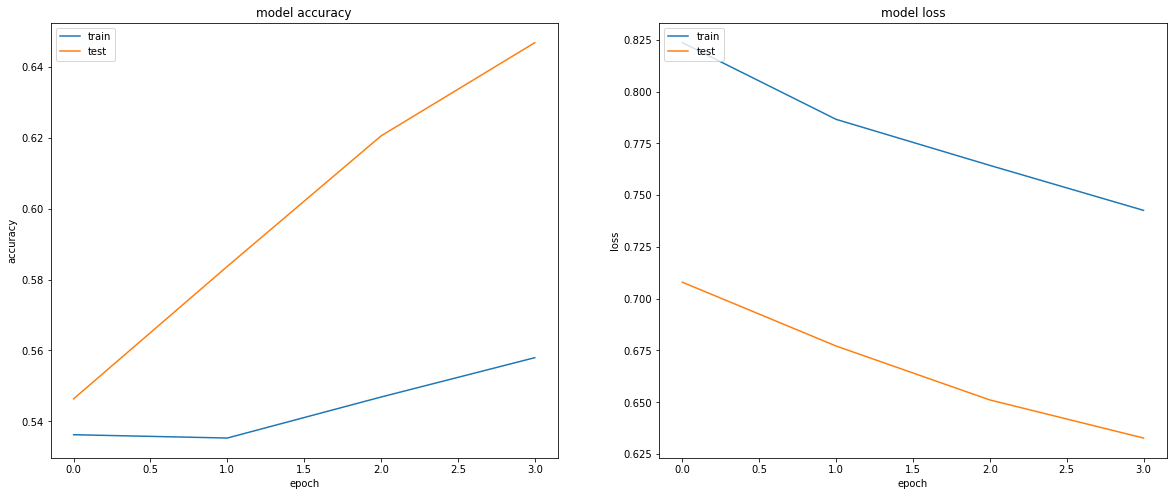

In [115]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [116]:
test_generator.reset()
V3.load_weights(VGGweights)

y_pred_keras2=V3.predict(valid_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1).ravel()

print("validation accuracy = " + str(y_pred_keras2[1]))


344/344 [==============================] - 150s 435ms/step
validation accuracy = 0.22542244


Confusion matrix, without normalization
[[21101  5120]
 [14311  3473]]


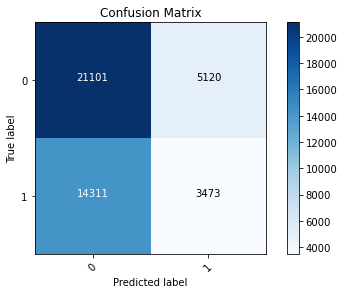

In [119]:
probabilities = y_pred_keras2
y_true = valid_generator.classes
y_pred = probabilities > 0.5

cm2 = confusion_matrix(y_true=valid_generator.classes, y_pred=probabilities>0.5)

plot_confusion_matrix(cm=cm2, classes=cm_plot_labels, title='Confusion Matrix')

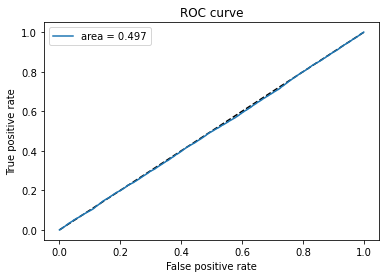

In [120]:
#plot ROC curve for VGG16
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred_keras2)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Check Performance on Test data

In [121]:
V3.load_weights(VGGweights)

testing = V3.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1).ravel()

print("Test accuracy = " + str(testing[1]))

344/344 [==============================] - 356s 1s/step
Test accuracy = 0.3606732


## ResNet50

In [125]:
dropout_fc = 0.5

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (60,60,3))

X1 = Sequential()

X1.add(conv_base)
X1.add(Flatten())
X1.add(Dense(256, use_bias=False))
X1.add(BatchNormalization())
X1.add(Activation("relu"))
X1.add(Dropout(dropout_fc))
X1.add(Dense(1, activation = "sigmoid"))

conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
X1.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [126]:
X1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               2097152   
_________________________________________________________________
batch_normalization_381 (Bat (None, 256)               1024      
_________________________________________________________________
activation_381 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

In [127]:
%%time 

early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 3)
checkpoint = ModelCheckpoint(filepath = rootdirectory + "Resnet.hdf5", verbose=1, save_best_only=True)

history2= X1.fit(train_generator,
      steps_per_epoch=200,
      validation_data=valid_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks = [early_stopping, checkpoint],
      epochs=4)


Epoch 1/4
200/200 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6634
Epoch 00001: val_loss improved from inf to 0.98327, saving model to data\Resnet.hdf5
200/200 [==============================] - 652s 3s/step - loss: 0.6274 - accuracy: 0.6634 - val_loss: 0.9833 - val_accuracy: 0.4111
Epoch 2/4
200/200 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6975
Epoch 00002: val_loss improved from 0.98327 to 0.75708, saving model to data\Resnet.hdf5
200/200 [==============================] - 512s 3s/step - loss: 0.5859 - accuracy: 0.6975 - val_loss: 0.7571 - val_accuracy: 0.5925
Epoch 3/4
200/200 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7079
Epoch 00003: val_loss improved from 0.75708 to 0.54665, saving model to data\Resnet.hdf5
200/200 [==============================] - 610s 3s/step - loss: 0.5651 - accuracy: 0.7079 - val_loss: 0.5467 - val_accuracy: 0.7342
Epoch 4/4
200/200 [==============================] - ETA

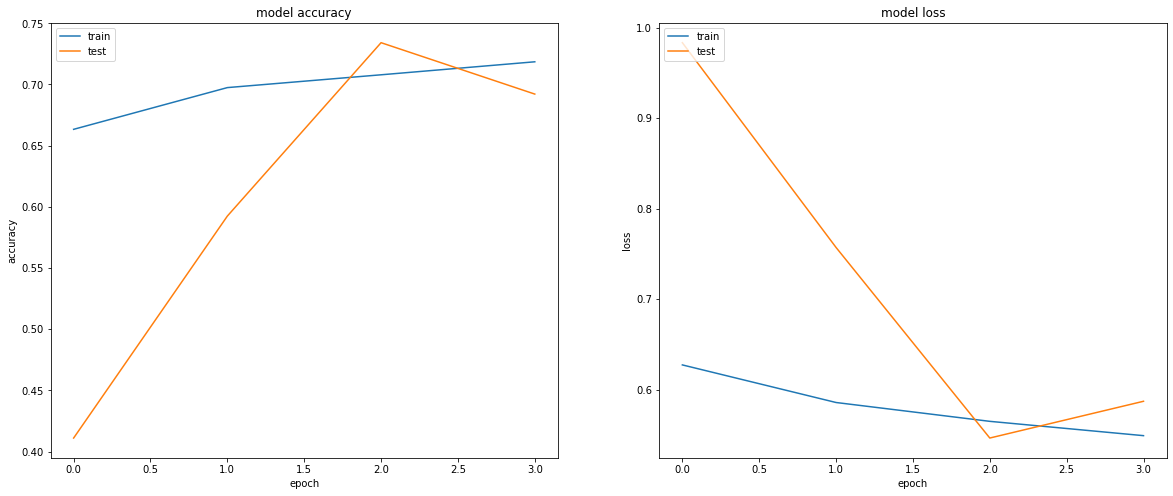

In [128]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#summarize history for loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Cross-Validation

In [129]:
test_generator.reset()

X1.load_weights(resnetw)
y_pred_keras3=X1.predict(valid_generator,
                            steps=STEP_SIZE_TEST_RN,
                            verbose=1)

print("Test accuracy = " + str(y_pred_keras3[1]))

344/344 [==============================] - 217s 631ms/step
Test accuracy = [0.5432903]


Confusion matrix, without normalization
[[20693  5528]
 [ 6167 11617]]


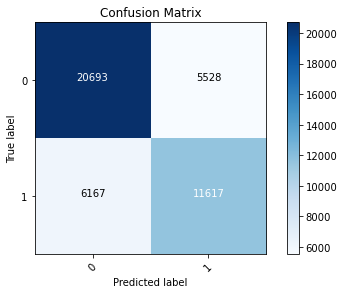

In [130]:
#plot confusion matrix for resnet50
probabilities = y_pred_keras3
y_true = valid_generator.classes
y_pred = probabilities > 0.5

cm3 = confusion_matrix(y_true=valid_generator.classes, y_pred=probabilities>0.5)

plot_confusion_matrix(cm=cm3, classes=cm_plot_labels, title='Confusion Matrix')

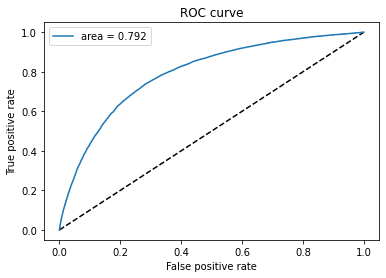

In [131]:
#ROC curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_generator.classes, y_pred_keras3)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Check performance on Testing data

In [132]:
X1.load_weights(resnetw)

testing = X1.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1).ravel()

print("Test accuracy = " + str(testing[1]))

344/344 [==============================] - 396s 1s/step
Test accuracy = 0.31755015
